In [9]:
import matplotlib.pyplot as plt
import numpy as np


In [26]:



class data_generater():
    def __init__(self, n0=3,n1=7,T=3000,firing_rate0=3,firing_rate1=0.15,frame_rate=30,
                 calcium_gamma=0.95, calcium_alpha=1,y_a = 1, y_b = 0.1,
                 gaussian_sn=0.1,seed = 0):
        self.n0 = n0
        self.n1 = n1
        self.T = T
        self.spike_lam0 = firing_rate0/frame_rate
        self.spike_lam1 = firing_rate1/frame_rate
        self.calcium_gamma = calcium_gamma
        self.calcium_alpha = calcium_alpha
        self.y_a = y_a
        self.y_b = y_b
        self.gaussian_sn = gaussian_sn
        self.seed = seed


    def gen_spike(self):
        np.random.seed(self.seed)
        s0 = np.random.poisson(lam = self.spike_lam0,size =(self.n0,self.T))
        s1 = np.random.poisson(lam = self.spike_lam1,size =(self.n1,self.T))
        s = np.vstack([s0,s1])
        self.spike = s

    def gen_calcium(self):

        s =self.spike
        c = np.zeros((self.n0 + self.n1,self.T))
        c[:,0] =self.calcium_alpha*s[:,0]
        for i in range(1,self.T):
            c[:,i] = self.calcium_gamma*c[:,i-1] + self.calcium_alpha*s[:,i]
        self.calcium = c



    def gen_observation_gaussian(self):
        np.random.seed(self.seed)
    
        y = self.calcium

        D,T = y.shape
        
        sn = self.gaussian_sn
        y =y+np.random.randn(D,T)*sn
       

        self.y = y

    def gen_data(self):
        seed=self.seed
        # np.random.seed(seed = seed)
        self.gen_spike()
        self.gen_calcium()
        self.gen_observation_gaussian()

        return self.y,self.calcium,self.spike




In [27]:
sim =  data_generater()
y,c,s = sim.gen_data()

In [28]:
s.shape[1]

3000

/var/folders/v9/ctrf9n_91nb_r6s_7zn75q1r0000gn/T/ipykernel_76319/124509035.py:4: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(np.arange(0,3000), s[i,:]*0.8-1.5,'g',markerfmt='none',basefmt='none',bottom = -1.5,


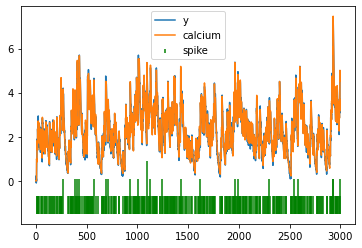

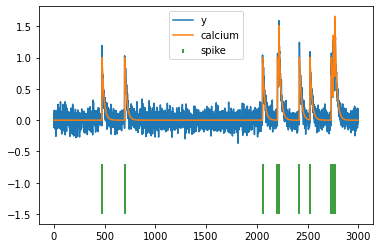

In [32]:
for i in [0,4]:
    plt.plot(y[i,:],label = 'y')
    plt.plot(c[i,:],label ='calcium')
    plt.stem(np.arange(0,3000), s[i,:]*0.8-1.5,'g',markerfmt='none',basefmt='none',bottom = -1.5,   
                                                use_line_collection=True,label = 'spike')
    plt.legend()
    plt.show()

Text(0, 0.5, 'Number of neurons')

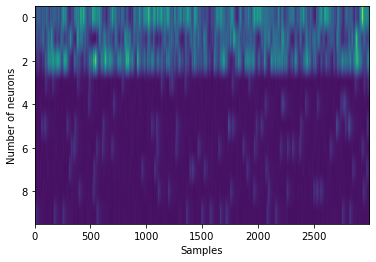

In [34]:
plt.imshow(y, aspect = 'auto')
plt.xlabel('Samples')
plt.ylabel('Number of neurons')

In [35]:
def PCA(y, D = 10):
    from sklearn.decomposition import PCA

    pca = PCA(n_components=D)
    v,s,ut = pca._fit(y.T)

    W = ut.T
 
    X = np.matmul(s*np.identity(len(s)),v.T)
    mu = y.mean(axis = 1)

    yq=np.matmul(W, X)+mu.reshape((-1,1))

    return W, X,yq

In [37]:
W,X,yq = PCA(y,D =10)

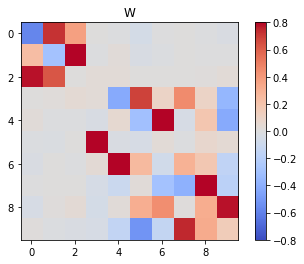

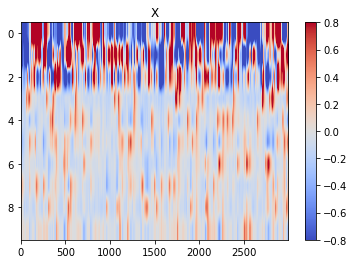

In [45]:
plt.imshow(W, cmap = 'coolwarm', vmin = -0.8, vmax = 0.8 ); plt.colorbar(); plt.title('W');plt.show()

plt.imshow(X,aspect ='auto', cmap = 'coolwarm', vmin = -0.8, vmax = 0.8 ); plt.colorbar(); plt.title('X');plt.show()

In [49]:
def BayesianPCA(y, D = 10,a = 1e-3,b = 1e-3):
    mu = y.mean(axis = 1)
    M,N = y.shape
    from bayespy.nodes import GaussianARD, Gamma, SumMultiply
    from bayespy.inference import  VB

    X = GaussianARD(0,1,shape=(D,), plates=(1,N),name ='X')
    alpha = Gamma(a,b,plates=(D,),name='alpha')
    W = GaussianARD(0,alpha,shape =(D,),plates =(M,1),name ='W')
    tau = Gamma(1e-5,1e-5,name='tau')
    W.initialize_from_random()
    X.initialize_from_random()

    F = SumMultiply('d,d->',W,X)
    Y = GaussianARD(F,tau,name ='Y')
    mu_ = y.mean(axis = 1)
    y_ = y-mu_.reshape(-1,1)
    Y.observe(y_)
    

    Q = VB(Y,W,X,alpha,tau)

    from bayespy.inference.vmp.transformations import RotateGaussianARD,RotationOptimizer
    X = Q['X']
    W = Q['W']
    alpha =Q['alpha']
    rot_X = RotateGaussianARD(X)
    rot_W = RotateGaussianARD(W,alpha)
   

    R = RotationOptimizer(rot_X, rot_W, D)
    Q.set_callback(R.rotate)

    Q.update(repeat =1000,verbose = True)
   
    W = np.squeeze(Q['W'].get_moments()[0])
    X = np.squeeze(Q['X'].get_moments()[0]).T
    yq = np.matmul(W, X)+mu.reshape((-1,1))
    return W, X,yq


In [50]:
W,X,yq = BayesianPCA(y, D = 10)

Iteration 1: loglike=-2.687504e+04 (0.029 seconds)
Iteration 2: loglike=-2.672259e+04 (0.088 seconds)
Iteration 3: loglike=-2.578574e+04 (0.098 seconds)
Iteration 4: loglike=-2.247058e+04 (0.083 seconds)
Iteration 5: loglike=-1.924982e+04 (0.058 seconds)
Iteration 6: loglike=-1.702146e+04 (0.125 seconds)
Iteration 7: loglike=-1.323174e+04 (0.041 seconds)
Iteration 8: loglike=-1.238402e+04 (0.039 seconds)
Iteration 9: loglike=-1.225884e+04 (0.029 seconds)
Iteration 10: loglike=-1.224454e+04 (0.053 seconds)
Iteration 11: loglike=-1.224310e+04 (0.057 seconds)
Iteration 12: loglike=-1.224293e+04 (0.019 seconds)
Iteration 13: loglike=-1.224291e+04 (0.112 seconds)
Converged at iteration 13.


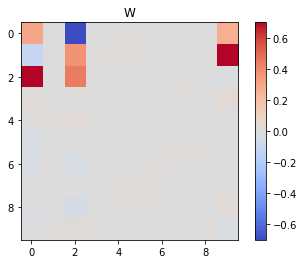

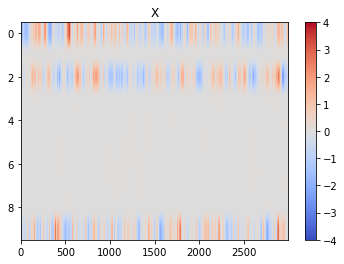

In [56]:
plt.imshow(W, cmap = 'coolwarm', vmin = -0.7, vmax = 0.7 ); plt.colorbar(); plt.title('W');plt.show()

plt.imshow(X,aspect ='auto', cmap = 'coolwarm', vmin = -4, vmax = 4 ); plt.colorbar(); plt.title('X');plt.show()